### 1. Imports et chargement des données


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [1]:
# Imports généraux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

# Configuration des plots
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style("whitegrid")


In [4]:
# Chargement du DataFrame traité (daily)
processed_dir = Path("data/processed")
# Lister les fichiers processed daily
files = list(processed_dir.glob("*_processed_daily.parquet"))
# Choisir une zone
zone_file = files[0]
zone = zone_file.stem.replace("_processed_daily","")
df = pd.read_parquet(zone_file)
print(f"Zone analysée : {zone}")


Zone analysée : Baleares


In [5]:
# Aperçu global
df.info()
display(df.head())
display(df.describe().T)
print("Valeurs manquantes par colonne :")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2803 entries, 2016-05-01 00:00:00+00:00 to 2024-01-02 00:00:00+00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_rmean_6   2803 non-null   float64
 1   demand         2803 non-null   float64
 2   rmean_7d       2803 non-null   float64
 3   temp_rmean_12  2803 non-null   float64
 4   lag_7d         2803 non-null   float64
 5   lag_1d         2803 non-null   float64
 6   temp_rmean_7   2803 non-null   float64
 7   lag_4d         2803 non-null   float64
 8   temp_rmean_3   2803 non-null   float64
 9   lag_30d        2803 non-null   float64
 10  lag_6d         2803 non-null   float64
 11  lag_3d         2803 non-null   float64
 12  lag_2d         2803 non-null   float64
dtypes: float64(13)
memory usage: 306.6 KB


,temp_rmean_6,demand,rmean_7d,temp_rmean_12,lag_7d,lag_1d,temp_rmean_7,lag_4d,temp_rmean_3,lag_30d,lag_6d,lag_3d,lag_2d
datetime,,,,,,,,,,,,,
2016-05-01 00:00:00+00:00,15.927778,13360.694,12135.243429,16.778472,12324.100,967.987,15.979762,14181.611,15.038889,14851.571,13882.115,14644.677,13922.559
2016-05-02 00:00:00+00:00,15.927778,14653.529,12245.445429,16.778472,13882.115,13360.694,15.979762,14644.677,15.038889,13712.197,13987.061,13922.559,967.987
2016-05-03 00:00:00+00:00,15.927778,14760.933,12355.998571,16.778472,13987.061,14653.529,15.979762,13922.559,15.038889,12713.297,14181.611,967.987,13360.694
2016-05-04 00:00:00+00:00,15.927778,14818.979,12447.051143,16.778472,14181.611,14760.933,15.979762,967.987,16.208333,14273.122,14644.677,13360.694,14653.529
2016-05-05 00:00:00+00:00,15.927778,15038.790,12503.353000,16.778472,14644.677,14818.979,15.979762,13360.694,16.729167,14546.843,13922.559,14653.529,14760.933


,count,mean,std,min,25%,50%,75%,max
temp_rmean_6,2803.0,18.521973,5.760712,7.220139,13.494097,18.010417,23.909375,30.082639
demand,2803.0,15506.007459,4380.400312,393.674000,13363.441500,14860.195000,17730.069500,27537.398000
rmean_7d,2803.0,15504.679196,3461.062622,8713.048429,13038.009143,14610.743000,17343.742857,26073.961286
temp_rmean_12,2803.0,18.528340,5.693737,7.967361,13.422743,17.937847,23.928993,29.267361
lag_7d,2803.0,15504.945984,4380.310862,393.674000,13360.859500,14857.999000,17730.069500,27537.398000
lag_1d,2803.0,15501.024113,4388.985752,393.674000,13360.859500,14857.999000,17730.069500,27537.398000
temp_rmean_7,2803.0,18.522498,5.747175,7.346429,13.510714,18.079762,23.925000,29.858929
lag_4d,2803.0,15506.346544,4379.775637,393.674000,13363.441500,14857.999000,17730.069500,27537.398000
temp_rmean_3,2803.0,18.519597,5.813544,6.763889,13.486806,18.000000,23.824306,30.768056
lag_30d,2803.0,15506.915548,4379.404980,393.674000,13377.003000,14857.999000,17730.069500,27537.398000


Valeurs manquantes par colonne :
temp_rmean_6     0
demand           0
rmean_7d         0
temp_rmean_12    0
lag_7d           0
lag_1d           0
temp_rmean_7     0
lag_4d           0
temp_rmean_3     0
lag_30d          0
lag_6d           0
lag_3d           0
lag_2d           0
dtype: int64


### 4. Série temporelle de la demande


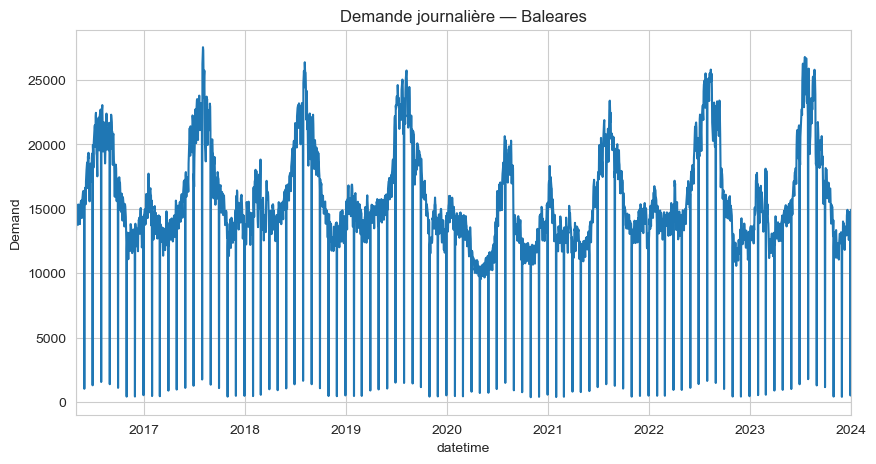

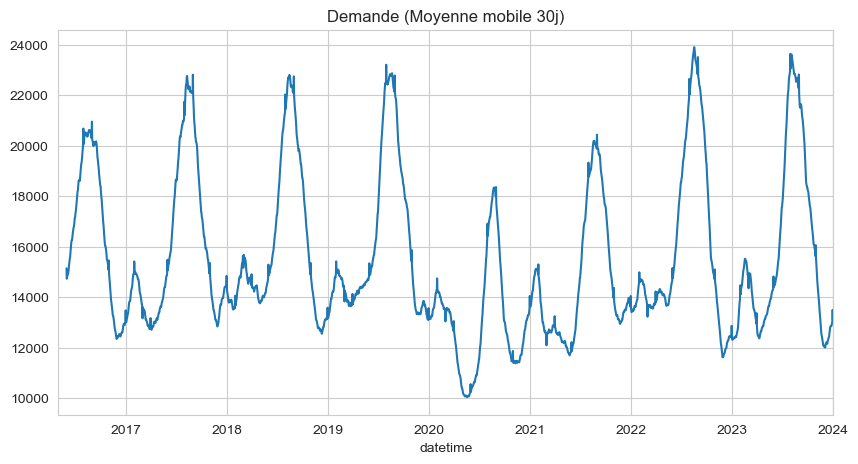

In [6]:
# 4. Série temporelle de la demande
plt.figure()
df['demand'].plot(title=f"Demande journalière — {zone}")
plt.ylabel("Demand")
plt.show()

# Moyenne mobile sur 30 jours
df['demand'].rolling(30).mean().plot(title="Demande (Moyenne mobile 30j)")
plt.show()

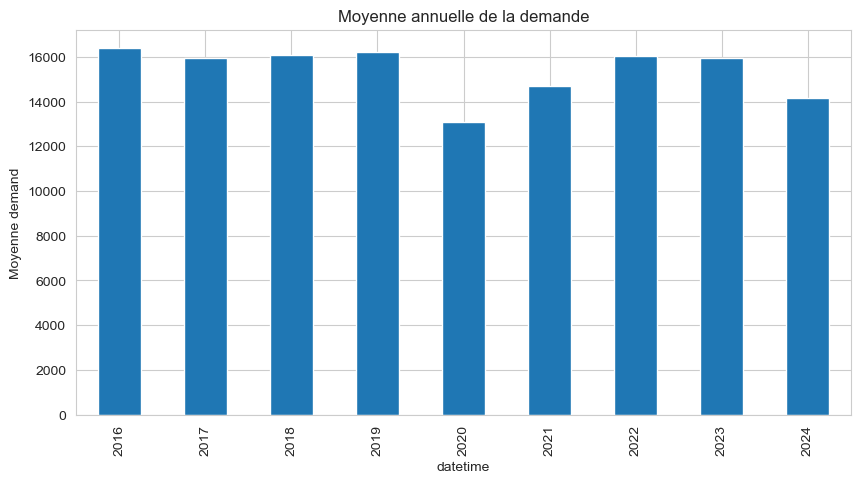

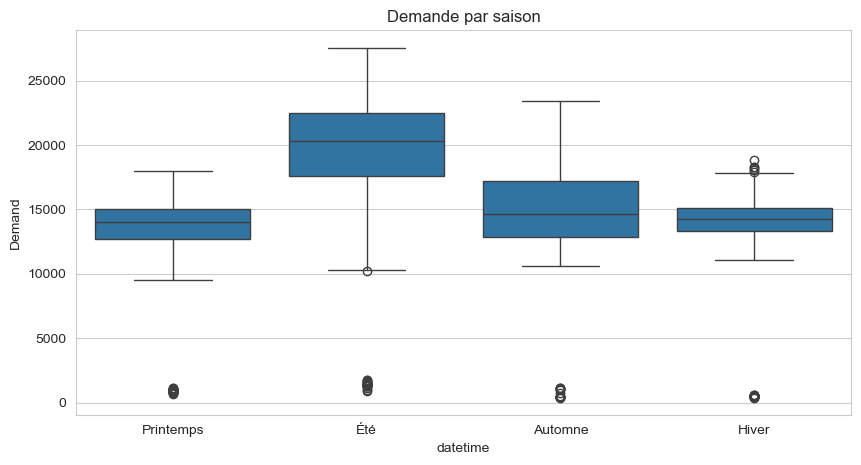

In [8]:
# 5. Boxplots par année et par saison
# Par année
df['demand'].groupby(df.index.year).mean().plot.bar(
    title="Moyenne annuelle de la demande")
plt.ylabel("Moyenne demand")
plt.show()

# Par saison
seasons = ((df.index.month%12 +3)//3).map({1:'Hiver',2:'Printemps',3:'Été',4:'Automne'})
plt.figure()
sns.boxplot(x=seasons, y=df['demand'])
plt.title("Demande par saison")
plt.ylabel("Demand")
plt.show()


### 6. Corrélations croisées

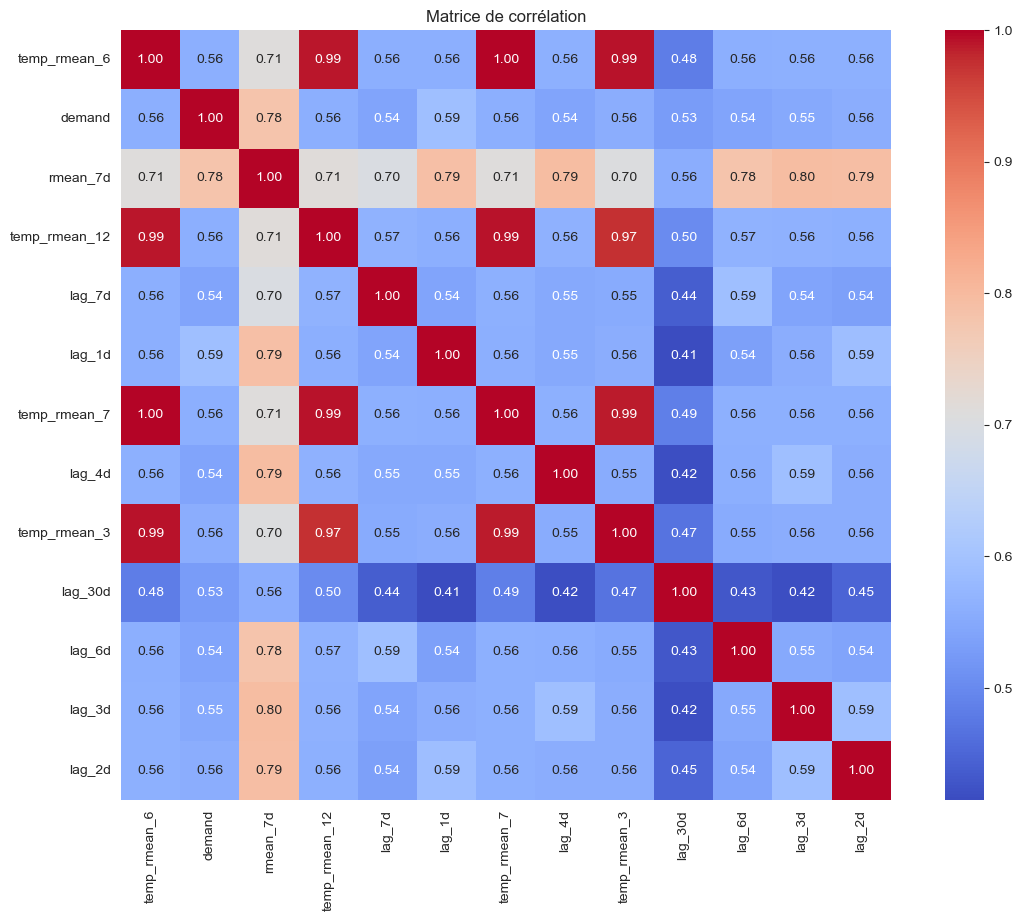

In [9]:
# 6. Corrélation des variables clés
# cols = ['demand','pvpc','temperature_2m','HDD','CDD','HeatIndex','WindChill']
corr = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.show()


### 7. Distribution de la demande et boxplot mensuel

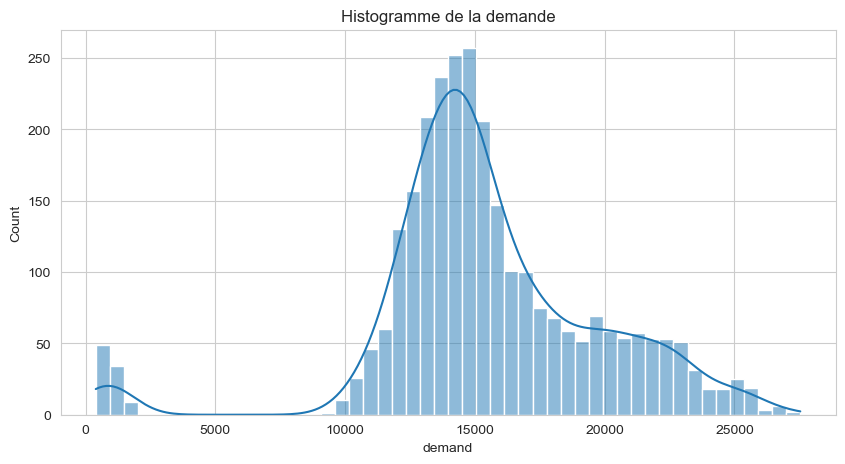

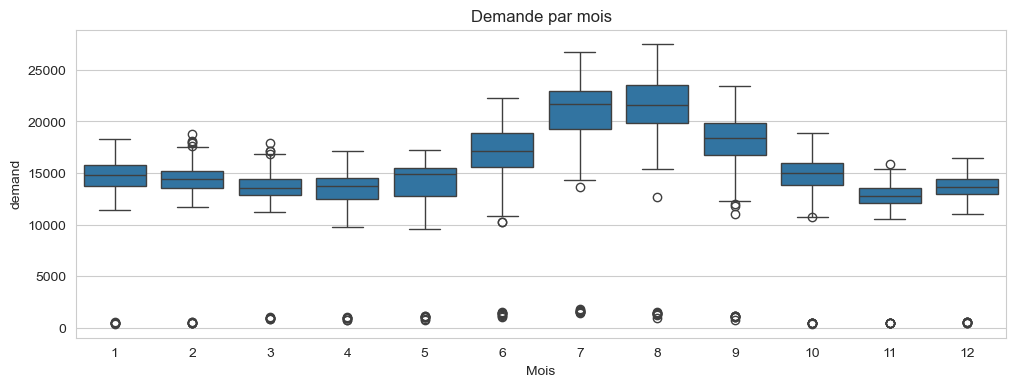

In [10]:
# 7. Distribution de la demande et boxplot mensuel
plt.figure()
sns.histplot(df['demand'], bins=50, kde=True)
plt.title("Histogramme de la demande")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x=df.index.month, y=df['demand'])
plt.title("Demande par mois")
plt.xlabel("Mois")
plt.show()


### 8. Analyse cyclique : jours de la semaine

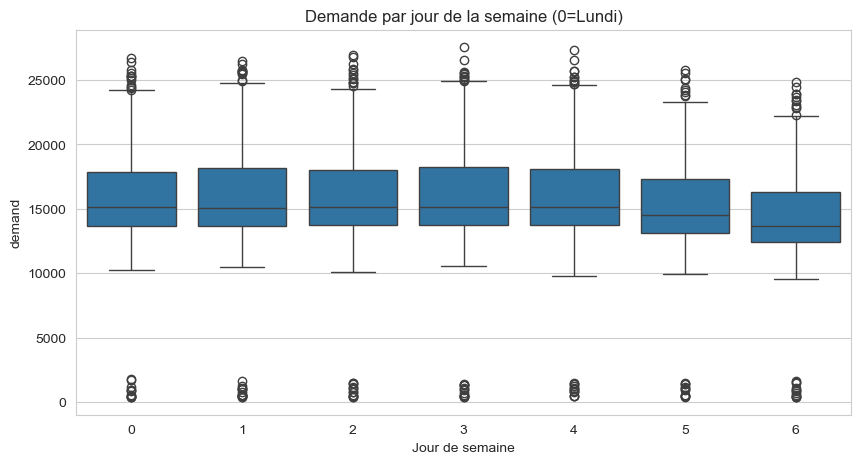

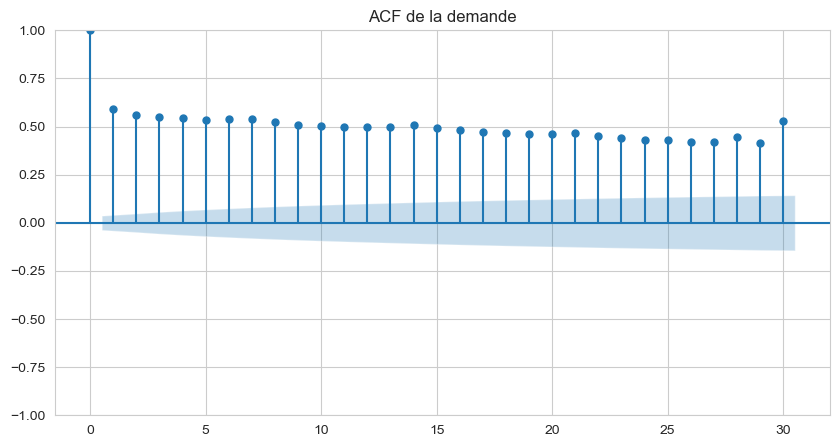

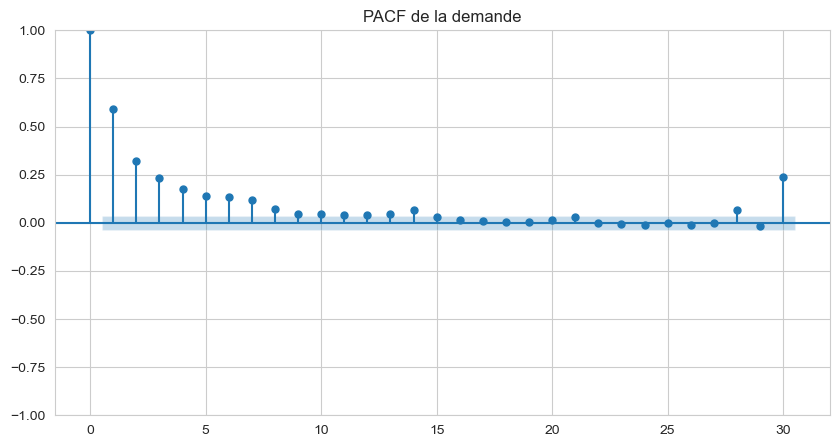

In [11]:
# 8. Analyse cyclique : jours de la semaine
plt.figure()
sns.boxplot(x=df.index.dayofweek, y=df['demand'])
plt.title("Demande par jour de la semaine (0=Lundi)")
plt.xlabel("Jour de semaine")
plt.show()

# Autocorrélation et PACF
plot_acf(df['demand'].dropna(), lags=30, title="ACF de la demande")
plt.show()
plot_pacf(df['demand'].dropna(), lags=30, title="PACF de la demande")
plt.show()


### 9. Effet des exogènes : scatter plots

In [12]:
# 9. Effet des exogènes : scatter plots
plt.figure()
sns.scatterplot(x='temperature_2m', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Température")
plt.show()

plt.figure()
sns.scatterplot(x='pvpc', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Prix PVPC")
plt.show()


ValueError: Could not interpret value `temperature_2m` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

### 10. Démarche jours fériés vs ouvrés

In [13]:
# Cellule 10. Démarche jours fériés vs ouvrés
plt.figure()
df.boxplot(column='demand', by='is_holiday')
plt.title("Demande ouvrés vs fériés")
plt.suptitle("")
plt.ylabel("Demand")
plt.show()



KeyError: 'is_holiday'

<Figure size 1000x500 with 0 Axes>

### 11. Détection d'anomalies (rolling z-score 7j)

Aucune anomalie (|z|>3) détectée


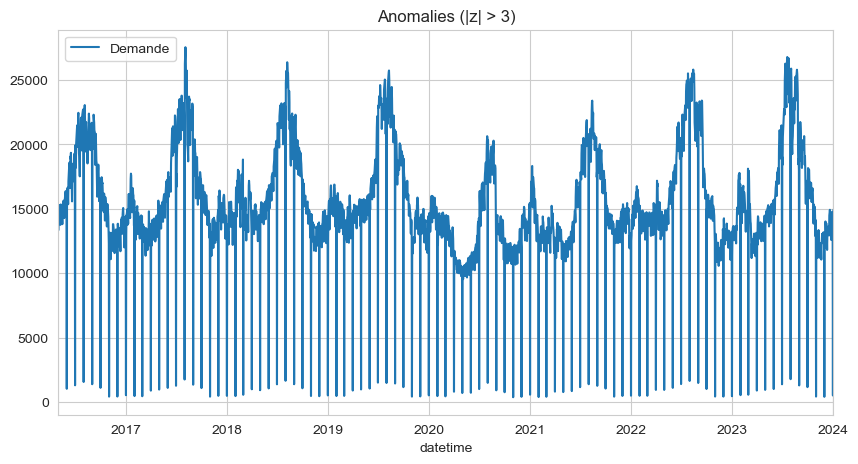

In [14]:
# 11. Détection d'anomalies (rolling z-score 7j)
rolling_mean = df['demand'].rolling(7).mean()
rolling_std  = df['demand'].rolling(7).std()
z_score = (df['demand'] - rolling_mean) / rolling_std

anoms = df[z_score.abs() > 3]
plt.figure()
df['demand'].plot(label='Demande')
if not anoms.empty:
    anoms['demand'].plot(style='ro', label='Anomalies')
else:
    print("Aucune anomalie (|z|>3) détectée")
plt.legend()
plt.title("Anomalies (|z| > 3)")
plt.show()


### 12. Conclusions textuelles


In [16]:
from IPython.display import Markdown
Markdown("""
**Conclusions provisoires :**
- **Tendances** : …
- **Saisonnalité** : …
- **Corrélations fortes** : ['rmean_7d', 'lag_1d', 'T_sq', 'temperature_2m',
 'temp_rmean_24h', 'temp_rmean_30h', 'HeatIndex', 'WindChill']
- **Anomalies détectées** : …
- **Prochaines étapes** : affiner features, tester modèles, valider stationnarité, etc.

         
     # Analyse des fonctions ACF et PACF de la demande

## Observations sur l'ACF (AutoCorrelation Function)
1. **Décroissance lente** : L'ACF montre une décroissance relativement lente vers zéro, ce qui est typique des processus non-stationnaires ou avec une tendance.
2. **Valeurs initiales élevées** : La corrélation à lag 1 est très élevée (proche de 1.00), ce qui suggère une forte dépendance entre les observations consécutives.
3. **Persistance des corrélations** : Les corrélations restent significatives pendant plusieurs périodes avant de diminuer.

## Observations sur la PACF (Partial AutoCorrelation Function)
1. **Pic significatif à lag 1** : La PACF présente un pic important au premier lag (environ 0.75) puis chute brutalement.
2. **Valeurs non significatives après lag 1** : Tous les lags suivants sont proches de zéro ou non significatifs.

## Interprétation et modélisation possible
1. **Processus AR(1)** : La forme de la PACF (un seul pic significatif) combinée avec la décroissance exponentielle de l'ACF suggère fortement un processus autorégressif d'ordre 1 (AR(1)).
2. **Équation potentielle** : Le modèle pourrait s'écrire: X_t = φX_{t-1} + ε_t, où φ ≈ 0.75 (estimé à partir du premier lag de la PACF).
3. **Stationnarité** : Comme le coefficient AR est inférieur à 1 en valeur absolue, le processus serait stationnaire.

""")



**Conclusions provisoires :**
- **Tendances** : …
- **Saisonnalité** : …
- **Corrélations fortes** : ['rmean_7d', 'lag_1d', 'T_sq', 'temperature_2m',
 'temp_rmean_24h', 'temp_rmean_30h', 'HeatIndex', 'WindChill']
- **Anomalies détectées** : …
- **Prochaines étapes** : affiner features, tester modèles, valider stationnarité, etc.

         
     # Analyse des fonctions ACF et PACF de la demande

## Observations sur l'ACF (AutoCorrelation Function)
1. **Décroissance lente** : L'ACF montre une décroissance relativement lente vers zéro, ce qui est typique des processus non-stationnaires ou avec une tendance.
2. **Valeurs initiales élevées** : La corrélation à lag 1 est très élevée (proche de 1.00), ce qui suggère une forte dépendance entre les observations consécutives.
3. **Persistance des corrélations** : Les corrélations restent significatives pendant plusieurs périodes avant de diminuer.

## Observations sur la PACF (Partial AutoCorrelation Function)
1. **Pic significatif à lag 1** : La PACF présente un pic important au premier lag (environ 0.75) puis chute brutalement.
2. **Valeurs non significatives après lag 1** : Tous les lags suivants sont proches de zéro ou non significatifs.

## Interprétation et modélisation possible
1. **Processus AR(1)** : La forme de la PACF (un seul pic significatif) combinée avec la décroissance exponentielle de l'ACF suggère fortement un processus autorégressif d'ordre 1 (AR(1)).
2. **Équation potentielle** : Le modèle pourrait s'écrire: X_t = φX_{t-1} + ε_t, où φ ≈ 0.75 (estimé à partir du premier lag de la PACF).
3. **Stationnarité** : Comme le coefficient AR est inférieur à 1 en valeur absolue, le processus serait stationnaire.



In [ ]:
# Chargement du DataFrame traité
processed_dir = Path("data/processed")
# Lister les fichiers processed
files = list(processed_dir.glob("*_processed_daily.parquet"))

# Choisir une zone
zone_file = files[1]
zone = zone_file.stem.replace("_processed_daily","")
df = pd.read_parquet(zone_file)
print(f"Zone analysée : {zone}")

In [ ]:
%pip install arch


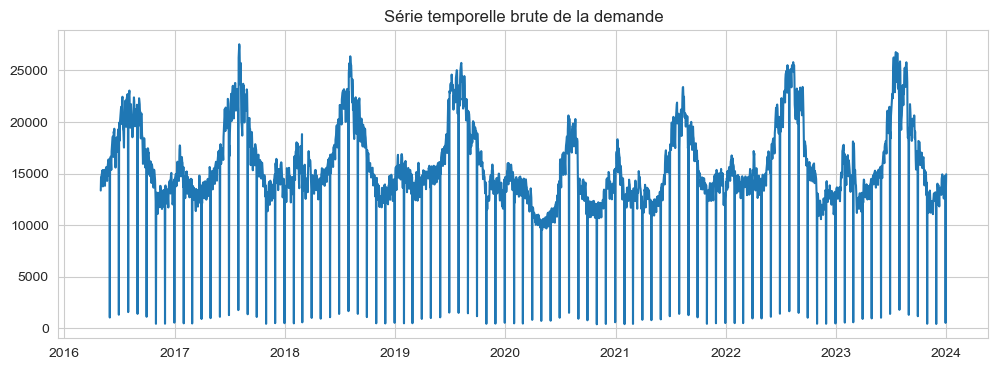

In [15]:
# from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

# Supposons que ta série cible est : df['demand']
series = df['demand']

# 1. Tracé de la série temporelle
plt.figure(figsize=(12,4))
plt.plot(series)
plt.title("Série temporelle brute de la demande")
plt.show()

In [16]:
# 2. ADF Test
print("→ Test ADF (Augmented Dickey-Fuller)")
result_adf = adfuller(series.dropna())
print(f"ADF Statistic: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]:.4f}")
for key, value in result_adf[4].items():
    print(f"   {key}: {value:.4f}")
if result_adf[1] < 0.05:
    print("✅ La série est stationnaire (rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire (échec du rejet de H0)")



→ Test ADF (Augmented Dickey-Fuller)
ADF Statistic: -4.2822
p-value: 0.0005
   1%: -3.4327
   5%: -2.8626
   10%: -2.5673
✅ La série est stationnaire (rejet de H0)


In [17]:
# 3. Test KPSS
print("\n→ Test KPSS")
result_kpss = kpss(series.dropna(), regression='c')
print(f"KPSS Statistic: {result_kpss[0]:.4f}")
print(f"p-value: {result_kpss[1]:.4f}")
for key, value in result_kpss[3].items():
    print(f"   {key}: {value:.4f}")
if result_kpss[1] < 0.05:
    print("❌ La série n'est pas stationnaire (rejet de H0)")
else:
    print("✅ La série est stationnaire (échec du rejet de H0)")



→ Test KPSS
KPSS Statistic: 0.2134
p-value: 0.1000
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
✅ La série est stationnaire (échec du rejet de H0)


C:\Users\NANKOULI\AppData\Local\Temp\ipykernel_18668\3252725422.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series.dropna(), regression='c')


In [10]:
# # 3. PP Test
# print("\n=== Test Phillips-Perron ===")
# pp_test = PhillipsPerron(df['demand'].dropna())
# print(pp_test.summary())

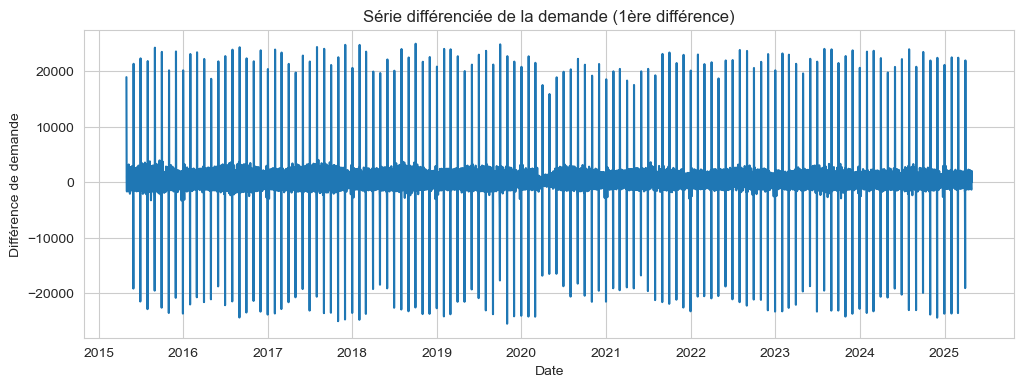

In [36]:
# 1. Différenciation
series_diff = series.diff().dropna()

# 2. Visualisation
plt.figure(figsize=(12, 4))
plt.plot(series_diff)
plt.title("Série différenciée de la demande (1ère différence)")
plt.xlabel("Date")
plt.ylabel("Différence de demande")
plt.grid(True)
plt.show()



In [37]:
# 3. Test ADF sur la série différenciée
result_adf = adfuller(series_diff)
print("→ Test ADF (série différenciée)")
print(f"ADF Statistic: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]:.4f}")
for key, value in result_adf[4].items():
    print(f"   {key}%: {value:.4f}")
if result_adf[1] < 0.05:
    print("✅ La série est stationnaire (rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire")


→ Test ADF (série différenciée)
ADF Statistic: -41.3776
p-value: 0.0000
   1%%: -3.4322
   5%%: -2.8623
   10%%: -2.5672
✅ La série est stationnaire (rejet de H0)


In [38]:
# 4. Test KPSS sur la série différenciée
result_kpss = kpss(series_diff, regression='c')
print("\n→ Test KPSS (série différenciée)")
print(f"KPSS Statistic: {result_kpss[0]:.4f}")
print(f"p-value: {result_kpss[1]:.4f}")
for key, value in result_kpss[3].items():
    print(f"   {key}%: {value:.4f}")
if result_kpss[1] > 0.05:
    print("✅ La série est stationnaire (échec du rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire")


→ Test KPSS (série différenciée)
KPSS Statistic: 0.2637
p-value: 0.1000
   10%%: 0.3470
   5%%: 0.4630
   2.5%%: 0.5740
   1%%: 0.7390
✅ La série est stationnaire (échec du rejet de H0)


C:\Users\NANKOULI\AppData\Local\Temp\ipykernel_18832\3355527342.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series_diff, regression='c')


je remarque que les series sont quasi stationnaires, il suffit de differencier une fois.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54376.657, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53716.320, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53035.915, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54374.657, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53013.979, Time=0.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53030.255, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=53017.528, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=53017.025, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53443.299, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53011.979, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53033.863, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53714.320, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53028.175, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]  

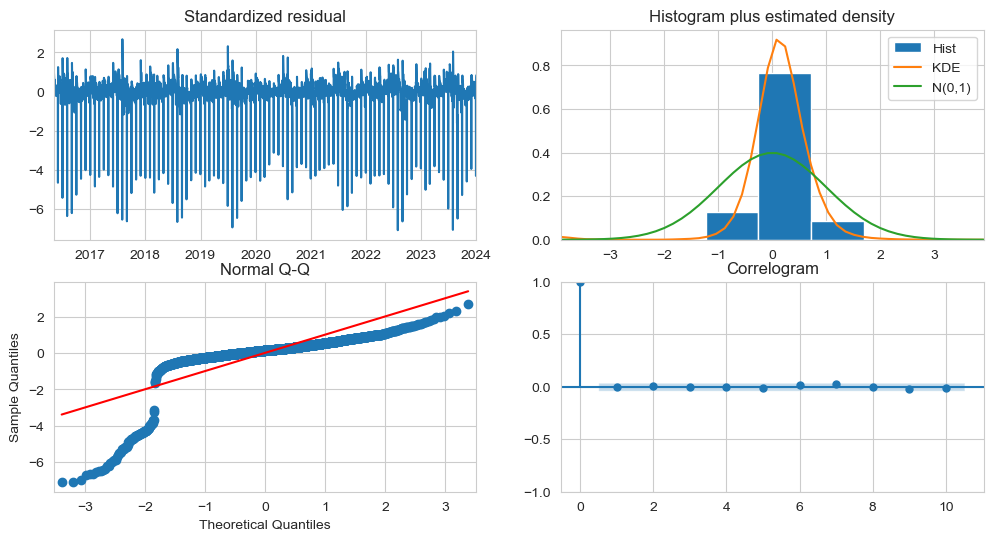

In [18]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Série de demande (différenciée ou non selon les besoins)
series = df['demand']

# Auto-ARIMA
model = pm.auto_arima(
    series,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,           # Détection automatique du degré de différenciation
    seasonal=False,   # On active le mode saisonnier plus tard si besoin
    trace=True,       # Affiche les essais
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Résumé
print(model.summary())

# Visualisation des résidus
model.plot_diagnostics(figsize=(12, 6))
plt.show()
